## 1) Loading Data and Packages + Util

In [1]:
import os
from google.colab import files
import shutil

import math
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing_extensions import final
import seaborn as sns
import random

from collections import OrderedDict

Load data from local folder

In [2]:
os.makedirs('/content/data', exist_ok=True)
destination_folder = '/content/data'
uploaded = files.upload()
for filename in uploaded.keys():
    shutil.move(filename, os.path.join(destination_folder, filename))

Saving full_fb_data.csv to full_fb_data.csv


Setup fitbit_data

In [23]:
full_fb_data = pd.read_csv('/content/data/full_fb_data.csv')

In [22]:
survey_features = ['diet', 'medication', 'symptoms']
rm_features = ['avgWeight_per_day', 'calories', 'heart', 'steps', 'hrv_dailyRmssd', 'hrv_deepRmssd', 'spo2_avg', 'temp/skin_nightlyRelative']
z_features = ['avgWeight_per_day_rm', 'calories_rm', 'heart_rm', 'steps_rm', 'hrv_dailyRmssd_rm', 'hrv_deepRmssd_rm', 'spo2_avg_rm', 'temp/skin_nightlyRelative_rm']

In [15]:
# Sort by date
full_fb_data['date'] = pd.to_datetime(full_fb_data['date'])
full_fb_data = full_fb_data.sort_values(by=['fitbit_user_id', 'date'])

# Shift survey columns
for col in survey_features:
  full_fb_data[col] = full_fb_data.groupby('fitbit_user_id')[col].shift(-1)

# Set remaining nan visit columns to 0
full_fb_data['visit_day'] = full_fb_data['visit_day'].fillna(0)

# Create has_visit column
full_fb_data['has_visit'] = 0
for user_id, group in full_fb_data.groupby('fitbit_user_id'):
    if group['visit_day'].sum() != 0:
        full_fb_data.loc[group.index, 'has_visit'] = 1

In [16]:
def extract_days_before_visit(df):
    output_rows = []

    for user_id, group in df.groupby('fitbit_user_id'):
        group = group.reset_index(drop=True)
        visit_indices = group.index[group['visit_day'] == 1].tolist()

        if not visit_indices:
            continue  # Skip users with no visits

        first_visit_idx = visit_indices[0]
        visit_day = group.loc[first_visit_idx, 'days']

        # Include all days ≤ visit day
        pre_visit_data = group[group['days'] <= visit_day].copy()

        # Add relative day to visit
        pre_visit_data['days_to_visit'] = pre_visit_data['days'] - visit_day
        pre_visit_data['fitbit_user_id'] = user_id

        output_rows.append(pre_visit_data)

    result_df = pd.concat(output_rows, axis=0).reset_index(drop=True)

    return result_df

In [17]:
visit_df = extract_days_before_visit(full_fb_data)
no_visit_df = full_fb_data[full_fb_data['has_visit'] == 0]

In [18]:
def rolling_mean(df, features, window_size = 3):
    df = df.copy()

    for feature in features:
        df[f'{feature}_rm'] = df.groupby('fitbit_user_id')[feature].rolling(window=window_size).mean().reset_index(0, drop=True)

    return df

In [19]:
visit_df = rolling_mean(visit_df, rm_features)
no_visit_df = rolling_mean(no_visit_df, rm_features)

In [21]:
def zscore_rolling(df, features, bootstrap_n=3):
    df_z = df.copy()

    for col in features:
        df_z[col + '_z'] = np.nan

        for user_id, group in df.groupby('fitbit_user_id'):
            series = group[col]
            z = []
            past_vals = []

            # First phase: collect the first 3 non-NaN values
            idxs = series.index.tolist()
            collected = 0

            for idx in idxs:
                val = series.loc[idx]

                if pd.isna(val):
                    z.append(np.nan)
                else:
                    past_vals.append(val)
                    collected += 1
                    z.append(None)  # placeholder to be replaced later

                if collected == bootstrap_n:
                    break

            # If we got enough to bootstrap, calculate mean/std and assign z-scores
            if len(past_vals) == bootstrap_n:
                mean = np.mean(past_vals)
                std = np.std(past_vals, ddof=1)
                z_vals = [(v - mean) / std if std > 0 else 0 for v in past_vals]

                # Replace placeholders
                for i in range(len(z)):
                    if z[i] is None:
                        z[i] = z_vals.pop(0)

            # Continue with the rest
            for idx in idxs[len(z):]:
                val = series.loc[idx]

                if pd.isna(val):
                    z.append(np.nan)
                    continue

                past_vals.append(val)
                mean = np.mean(past_vals)
                std = np.std(past_vals, ddof=1)
                z_val = (val - mean) / std if std > 0 else 0
                z.append(z_val)

            df_z.loc[series.index, col + '_z'] = z

    return df_z

In [24]:
visit_df = zscore_rolling(visit_df, z_features)
no_visit_df = zscore_rolling(no_visit_df, z_features)

/tmp/ipython-input-21-1259931419.py:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, None, None, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan

In [27]:
def extract_3wk_no_visits(df, window_days=22, max_windows=3, seed=123):
    np.random.seed(seed)
    output_rows = []

    for user_id, group in df.groupby('fitbit_user_id'):
        group = group.reset_index(drop=True)

        min_day = group['days'].min()
        max_day = group['days'].max()

        possible_starts = list(range(min_day, max_day - window_days + 1))
        np.random.shuffle(possible_starts)

        windows_added = 0

        for start in possible_starts:
            end = start + window_days
            window = group[(group['days'] >= start) & (group['days'] < end)].copy()

            if len(window) == window_days:  # Complete window
                window['days_to_window'] = window['days'] - end + 1
                window['fitbit_user_id'] = user_id
                output_rows.append(window)
                windows_added += 1

            if windows_added >= max_windows:
                break

    return pd.concat(output_rows, axis=0).reset_index(drop=True)

In [42]:
def extract_3wk_random_visits(df, window_days=22, max_windows=3, days_before = 21, exclude_window_before_visit=False, seed = 123):
    np.random.seed(seed)
    output_rows = []

    for user_id, group in df.groupby('fitbit_user_id'):
        group = group.reset_index(drop=True)

        first_visit_day = group['days'].max()

        # Define max allowable end day based on flag
        if exclude_window_before_visit:
            max_end_day = first_visit_day - days_before  # force entire window before visit window
        else:
            max_end_day = first_visit_day  # allow any window before visit

        max_start_day = max_end_day - window_days

        if max_start_day <= 0:
            continue  # not enough room for even one window

        possible_starts = list(range(max_start_day + 1))
        np.random.shuffle(possible_starts)

        windows_added = 0

        for start_day in possible_starts:
            end_day = start_day + window_days
            window = group[(group['days'] >= start_day) & (group['days'] < end_day)].copy()

            if len(window) == window_days:
                # Align to end of window like other no-visit functions
                window['days_to_window'] = window['days'] - (end_day - 1)
                window['fitbit_user_id'] = user_id
                output_rows.append(window)
                windows_added += 1

            if windows_added >= max_windows:
                break

    return pd.concat(output_rows, axis=0).reset_index(drop=True)

In [43]:
visit_3wk = visit_df[visit_df['days_to_visit'] >= -21]
no_visit_3wk = extract_3wk_no_visits(no_visit_df)
random_visit_3wk = extract_3wk_random_visits(visit_df)

In [44]:
visit_3wk.to_csv('/content/data/visit_3wk.csv', index=False)
no_visit_3wk.to_csv('/content/data/no_visit_3wk.csv', index=False)
random_visit_3wk.to_csv('/content/data/random_visit_3wk.csv', index=False)

files.download('/content/data/visit_3wk.csv')
files.download('/content/data/no_visit_3wk.csv')
files.download('/content/data/random_visit_3wk.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 2a) Graphing Functions

In [26]:
def drop_nan_user(df, feature):
    valid_users = df.groupby('fitbit_user_id')[feature].apply(lambda x: not x.isna().all())
    valid_user_ids = valid_users[valid_users].index

    return df[df['fitbit_user_id'].isin(valid_user_ids)].reset_index(drop=True)

In [45]:
def plot_feature_comparison(df1, df2, feature, time_col1='days_to_visit', time_col2='days_to_window', label1='Visit Users', label2='No-Visit Users', bin_continuous=False, n_bins=10):
    # ------------------- Line Plot -------------------
    fig, ax = plt.subplots(figsize=(12, 6))

    # Group by time and compute mean + std
    grouped1 = df1.groupby(time_col1)[feature]
    avg1 = grouped1.mean()
    std1 = grouped1.std()

    grouped2 = df2.groupby(time_col2)[feature]
    avg2 = grouped2.mean()
    std2 = grouped2.std()

    x1 = avg1.index.values
    y1 = avg1.values.astype(float)
    std1_vals = std1.reindex(avg1.index).fillna(0).values.astype(float)

    x2 = avg2.index.values
    y2 = avg2.values.astype(float)
    std2_vals = std2.reindex(avg2.index).fillna(0).values.astype(float)

    # Plot
    ax.plot(x1, y1, marker='o', label=label1)
    ax.fill_between(x1, y1 - std1_vals, y1 + std1_vals, alpha=0.2)

    ax.plot(x2, y2, marker='o', label=label2)
    ax.fill_between(x2, y2 - std2_vals, y2 + std2_vals, alpha=0.2)

    ax.set_title(f"Average {feature} Over Time")
    ax.set_xlabel("Days")
    ax.set_ylabel(f"Average {feature}")
    ax.axvline(0, color='red', linestyle='--', label='Event Day')
    ax.grid(True)
    ax.legend()

    plt.tight_layout()
    plt.show()

     # ------------------- Helper to prepare bar plot data -------------------
    def prepare_for_stacked(df, tcol):
        df = df.copy()
        if bin_continuous:
            df[feature] = df[feature].apply(lambda x: 'Missing' if pd.isna(x) else 'Non-missing')
        else:
            df[feature] = df[feature].fillna('Missing').astype(str)
        return df.groupby([tcol, feature]).size().unstack(fill_value=0)

    ct1 = prepare_for_stacked(df1, time_col1)
    ct2 = prepare_for_stacked(df2, time_col2)

    # ------------------- Stacked Bar Plot (Counts) -------------------
    fig, axs = plt.subplots(1, 2, figsize=(12, 3))
    ct1.plot(kind='bar', stacked=True, ax=axs[0])
    axs[0].set_title(f"{feature} by {time_col1} ({label1}) - Counts")
    axs[0].set_xlabel(time_col1)
    axs[0].set_ylabel("Count")

    ct2.plot(kind='bar', stacked=True, ax=axs[1])
    axs[1].set_title(f"{feature} by {time_col2} ({label2}) - Counts")
    axs[1].set_xlabel(time_col2)
    axs[1].set_ylabel("Count")
    plt.tight_layout()
    plt.show()

    # ------------------- Stacked Bar Plot (Percentages) -------------------
    pct1 = ct1.div(ct1.sum(axis=1), axis=0).fillna(0)
    pct2 = ct2.div(ct2.sum(axis=1), axis=0).fillna(0)

    fig, axs = plt.subplots(1, 2, figsize=(12, 3))
    pct1.plot(kind='bar', stacked=True, ax=axs[0])
    axs[0].set_title(f"{feature} by {time_col1} ({label1}) - Percentages")
    axs[0].set_xlabel(time_col1)
    axs[0].set_ylabel("Proportion")

    pct2.plot(kind='bar', stacked=True, ax=axs[1])
    axs[1].set_title(f"{feature} by {time_col2} ({label2}) - Percentages")
    axs[1].set_xlabel(time_col2)
    axs[1].set_ylabel("Proportion")

    plt.tight_layout()
    plt.show()

In [46]:
def plot_feature_comparison_3(df1, df2, df3, feature, time_col1='days_to_visit', time_col2='days_to_window', time_col3='days_to_window', label1='Visit Users', label2='No-Visit Users', label3='Random Visit Users', bin_continuous=False, n_bins=10):
    # ------------------- Line Plot -------------------
    fig, ax = plt.subplots(figsize=(18, 6))

    # Group by time and compute mean# Group by time and compute mean + std
    grouped1 = df1.groupby(time_col1)[feature]
    avg1 = grouped1.mean()
    std1 = grouped1.std()

    grouped2 = df2.groupby(time_col2)[feature]
    avg2 = grouped2.mean()
    std2 = grouped2.std()

    grouped3 = df3.groupby(time_col3)[feature]
    avg3 = grouped3.mean()
    std3 = grouped3.std()

    x1 = avg1.index.values
    y1 = avg1.values.astype(float)
    std1_vals = std1.reindex(avg1.index).fillna(0).values.astype(float)

    x2 = avg2.index.values
    y2 = avg2.values.astype(float)
    std2_vals = std2.reindex(avg2.index).fillna(0).values.astype(float)

    x3 = avg3.index.values
    y3 = avg3.values.astype(float)
    std3_vals = std3.reindex(avg3.index).fillna(0).values.astype(float)

    # Plot
    ax.plot(x1, y1, marker='o', label=label1)
    ax.fill_between(x1, y1 - std1_vals, y1 + std1_vals, alpha=0.2)

    ax.plot(x2, y2, marker='o', label=label2)
    ax.fill_between(x2, y2 - std2_vals, y2 + std2_vals, alpha=0.2)

    ax.plot(x3, y3, marker='o', label=label3)
    ax.fill_between(x3, y3 - std3_vals, y3 + std3_vals, alpha=0.2)

    ax.set_title(f"Average {feature} Over Time")
    ax.set_xlabel("Days")
    ax.set_ylabel(f"Average {feature}")
    ax.axvline(0, color='red', linestyle='--', label='Event Day')
    ax.grid(True)
    ax.legend()

    plt.tight_layout()
    plt.show()

     # ------------------- Helper to prepare bar plot data -------------------
    def prepare_for_stacked(df, tcol):
        df = df.copy()
        if bin_continuous:
            df[feature] = df[feature].apply(lambda x: 'Missing' if pd.isna(x) else 'Non-missing')
        else:
            df[feature] = df[feature].fillna('Missing').astype(str)
        return df.groupby([tcol, feature]).size().unstack(fill_value=0)

    ct1 = prepare_for_stacked(df1, time_col1)
    ct2 = prepare_for_stacked(df2, time_col2)
    ct3 = prepare_for_stacked(df3, time_col3)

    # ------------------- Stacked Bar Plot (Counts) -------------------
    fig, axs = plt.subplots(1, 3, figsize=(18, 3))
    ct1.plot(kind='bar', stacked=True, ax=axs[0])
    axs[0].set_title(f"{feature} by {time_col1} ({label1}) - Counts")
    axs[0].set_xlabel(time_col1)
    axs[0].set_ylabel("Count")

    ct2.plot(kind='bar', stacked=True, ax=axs[1])
    axs[1].set_title(f"{feature} by {time_col2} ({label2}) - Counts")
    axs[1].set_xlabel(time_col2)
    axs[1].set_ylabel("Count")

    ct3.plot(kind='bar', stacked=True, ax=axs[2])
    axs[2].set_title(f"{feature} by {time_col3} ({label3}) - Counts")
    axs[2].set_xlabel(time_col3)
    axs[2].set_ylabel("Count")

    plt.tight_layout()
    plt.show()

    # ------------------- Stacked Bar Plot (Percentages) -------------------
    pct1 = ct1.div(ct1.sum(axis=1), axis=0).fillna(0)
    pct2 = ct2.div(ct2.sum(axis=1), axis=0).fillna(0)
    pct3 = ct3.div(ct3.sum(axis=1), axis=0).fillna(0)

    fig, axs = plt.subplots(1, 3, figsize=(18, 3))
    pct1.plot(kind='bar', stacked=True, ax=axs[0])
    axs[0].set_title(f"{feature} by {time_col1} ({label1}) - Percentages")
    axs[0].set_xlabel(time_col1)
    axs[0].set_ylabel("Proportion")

    pct2.plot(kind='bar', stacked=True, ax=axs[1])
    axs[1].set_title(f"{feature} by {time_col2} ({label2}) - Percentages")
    axs[1].set_xlabel(time_col2)
    axs[1].set_ylabel("Proportion")

    pct3.plot(kind='bar', stacked=True, ax=axs[2])
    axs[2].set_title(f"{feature} by {time_col3} ({label3}) - Percentages")
    axs[2].set_xlabel(time_col3)
    axs[2].set_ylabel("Proportion")

    plt.tight_layout()
    plt.show()

## 2b) Graphing

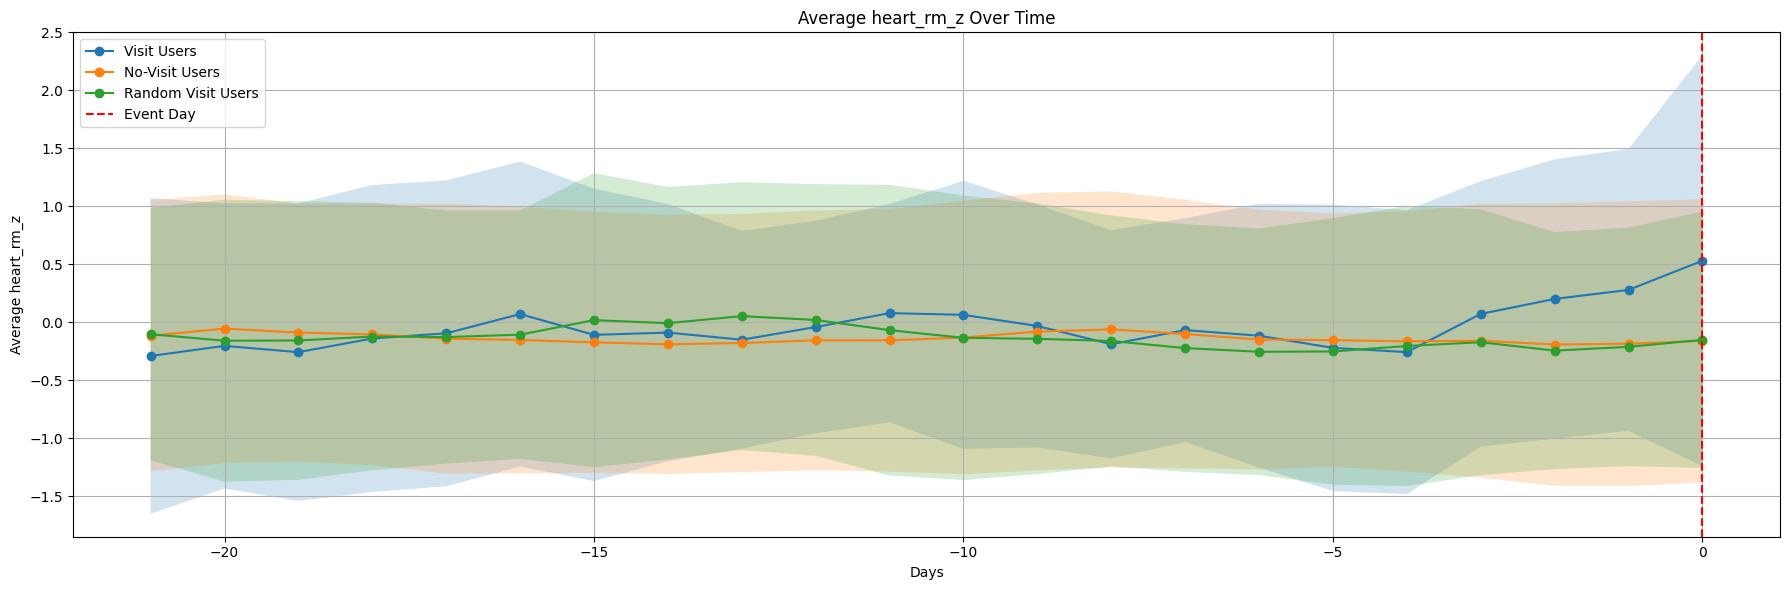

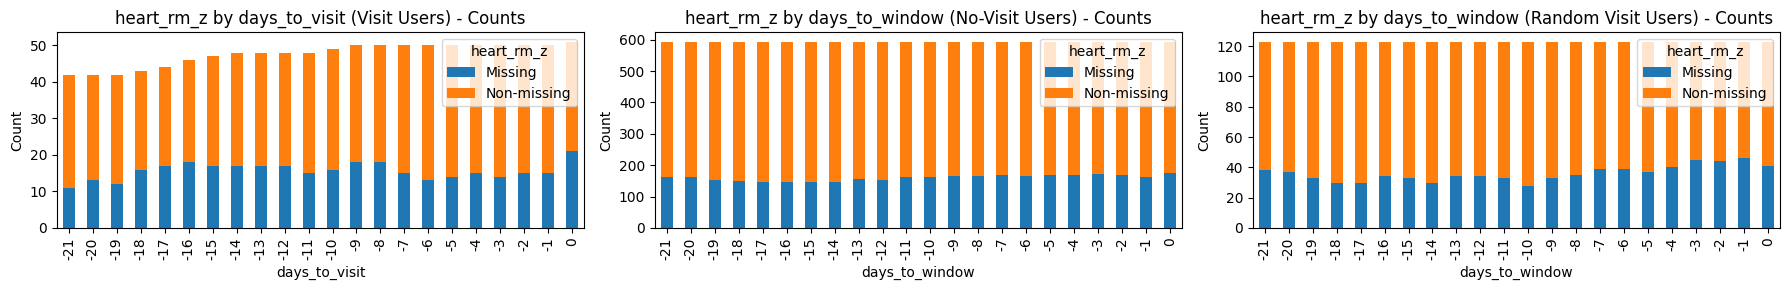

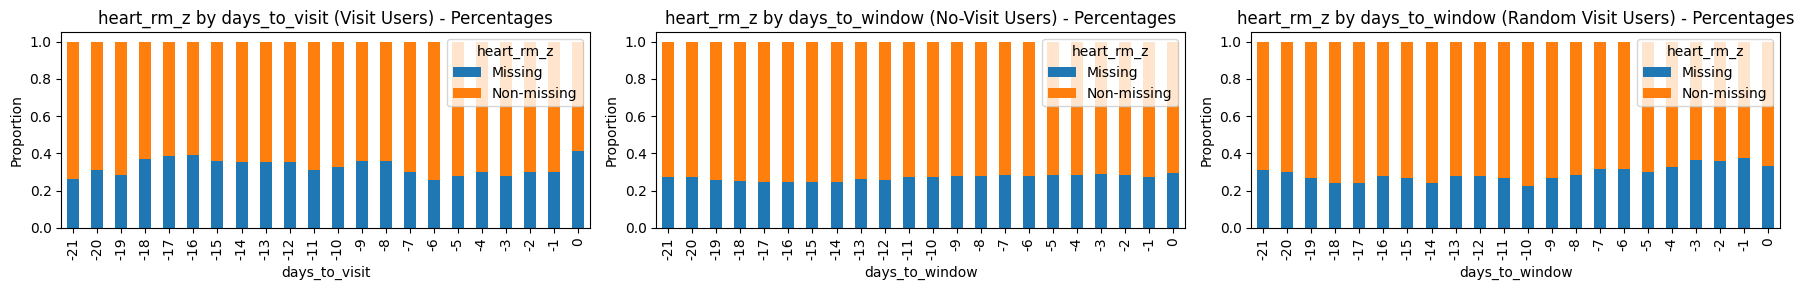

In [48]:
plot_feature_comparison_3(visit_3wk, no_visit_3wk, random_visit_3wk, 'heart_rm_z', bin_continuous=True)

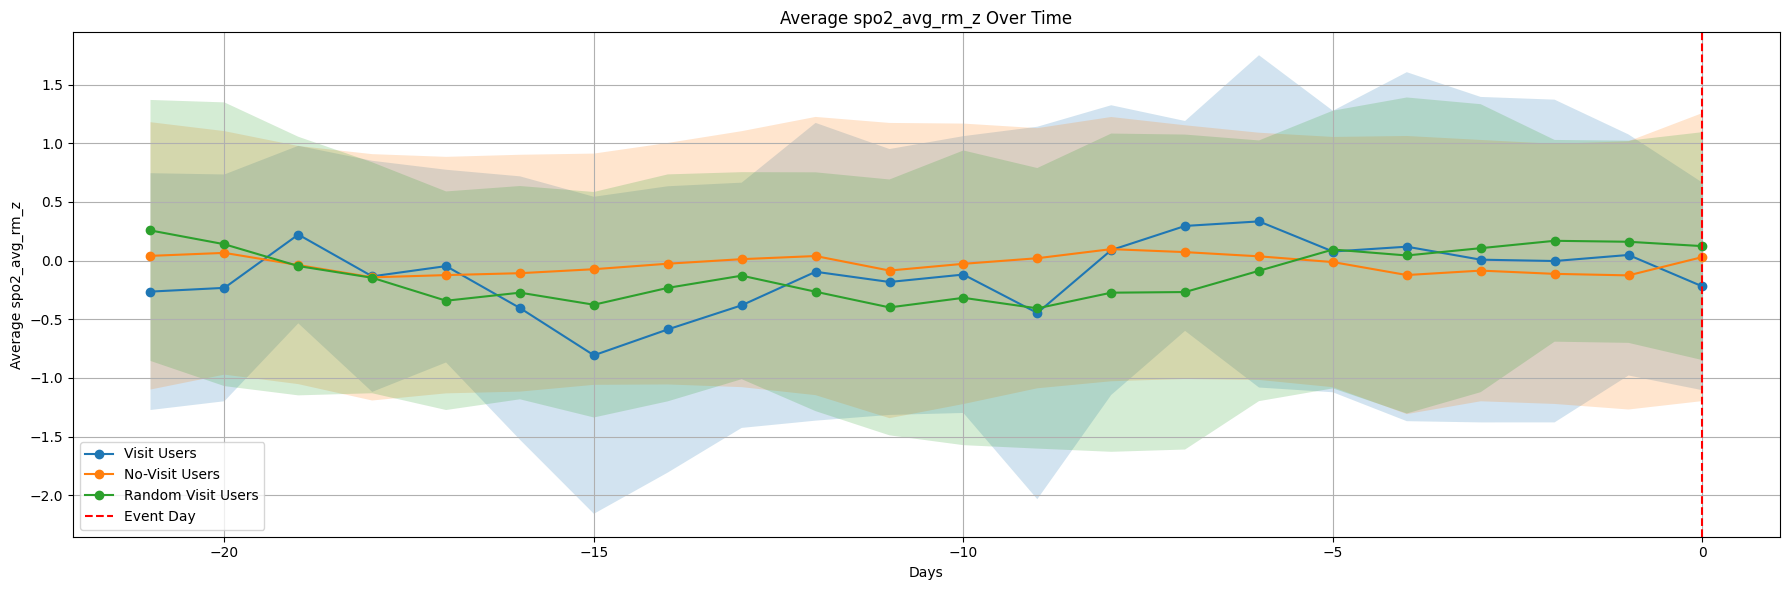

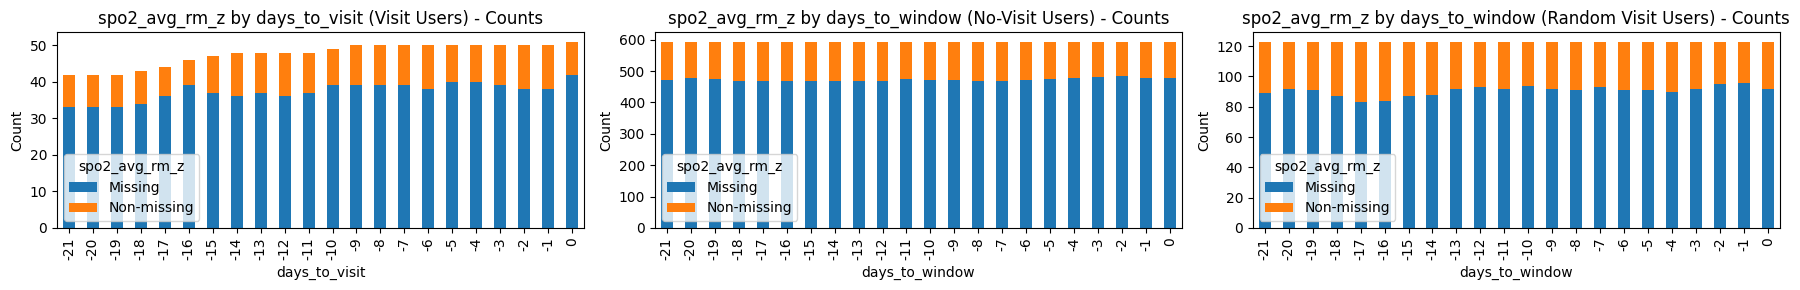

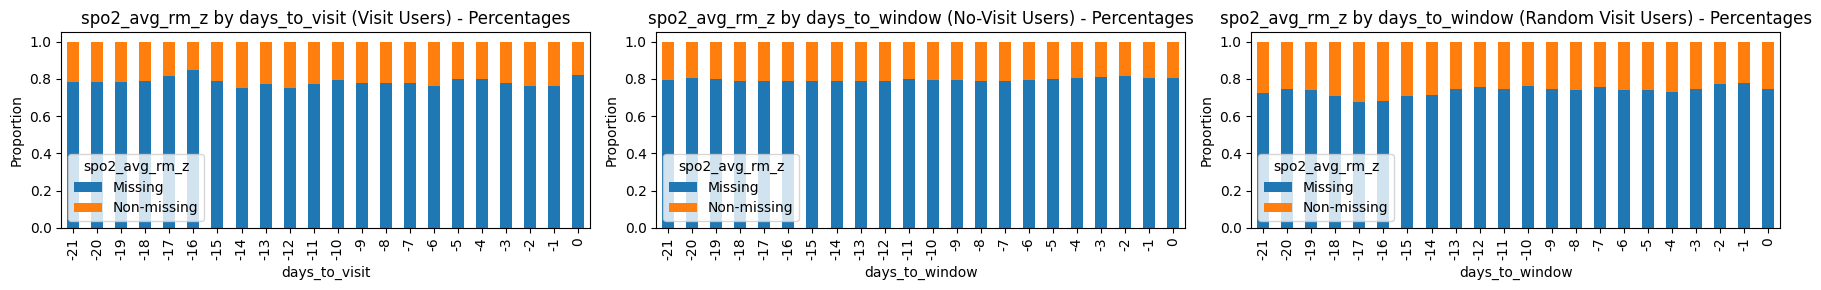

In [49]:
plot_feature_comparison_3(visit_3wk, no_visit_3wk, random_visit_3wk, 'spo2_avg_rm_z', bin_continuous=True)

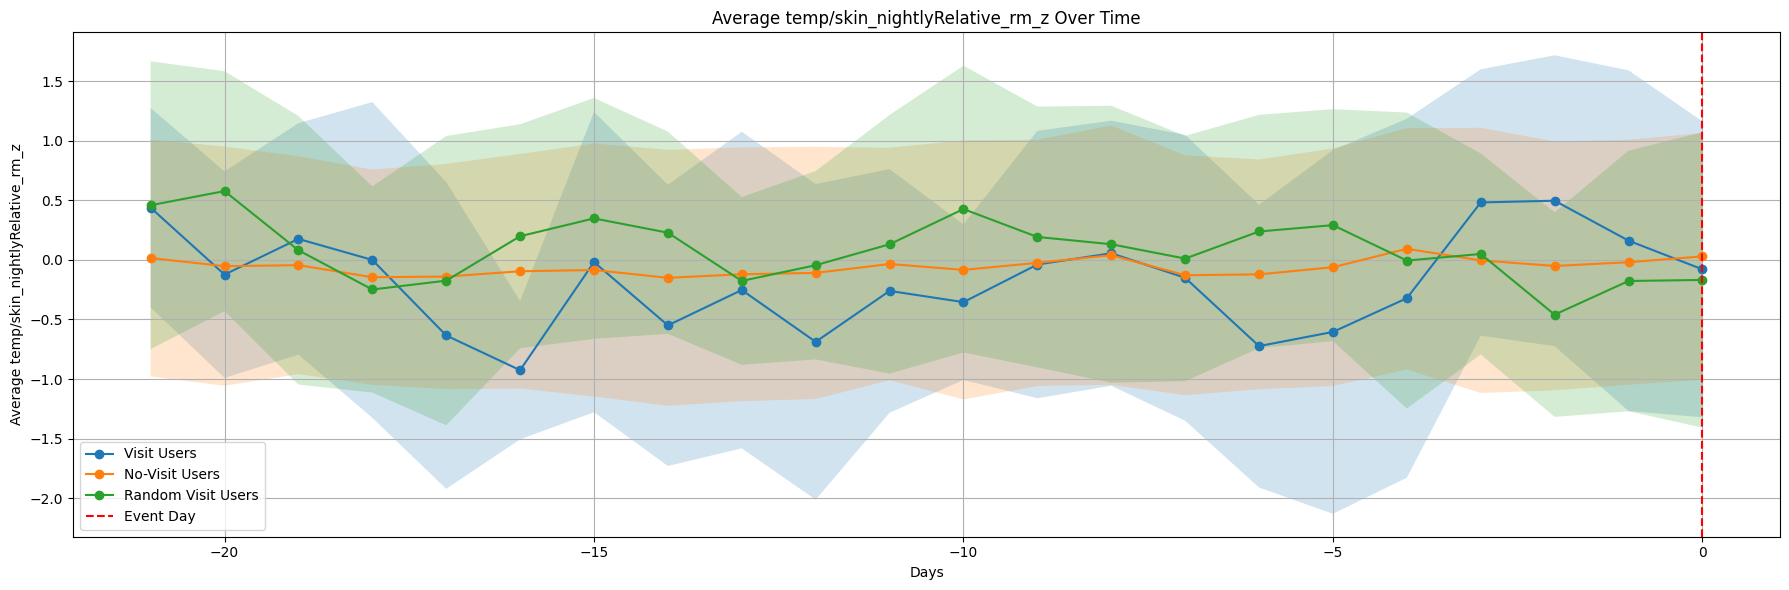

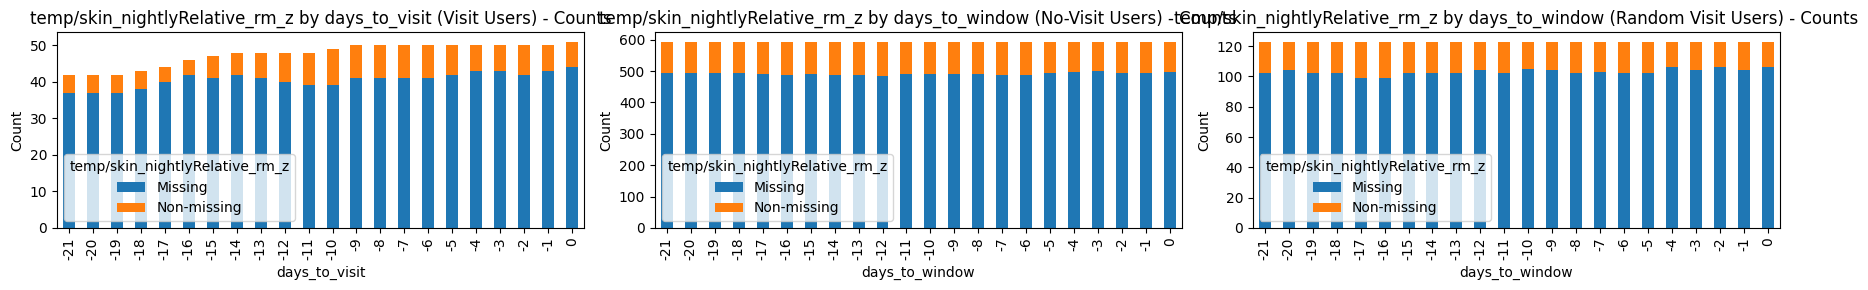

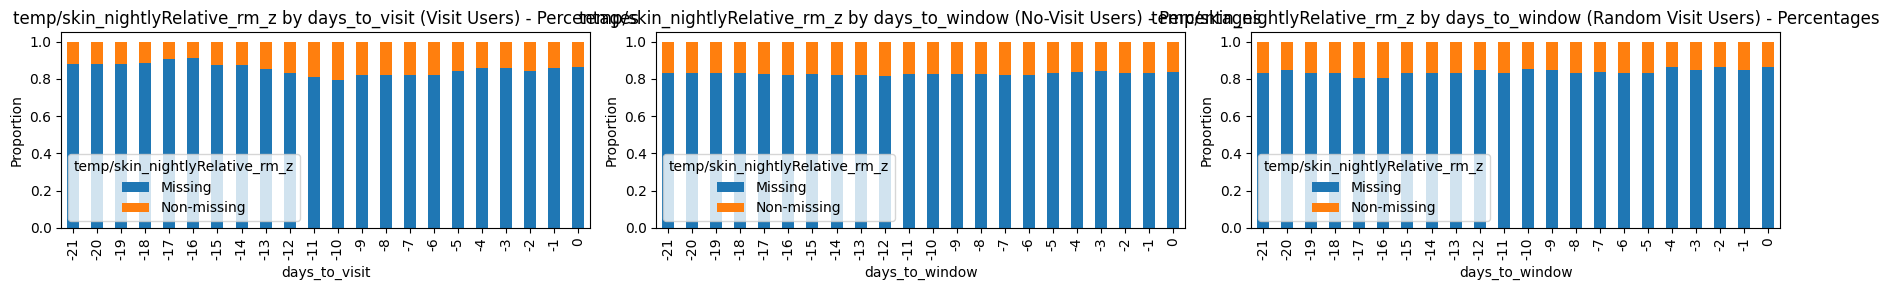

In [50]:
plot_feature_comparison_3(visit_3wk, no_visit_3wk, random_visit_3wk, 'temp/skin_nightlyRelative_rm_z', bin_continuous=True)

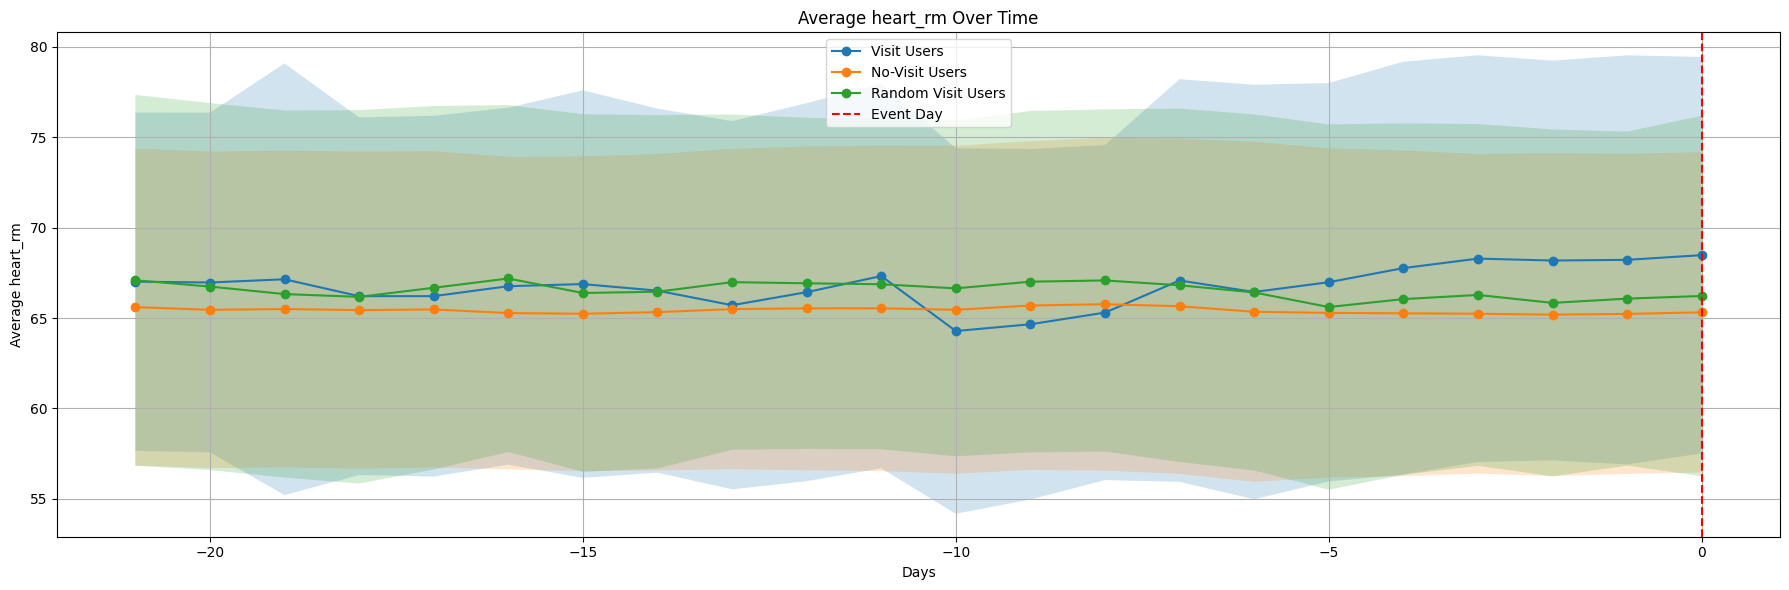

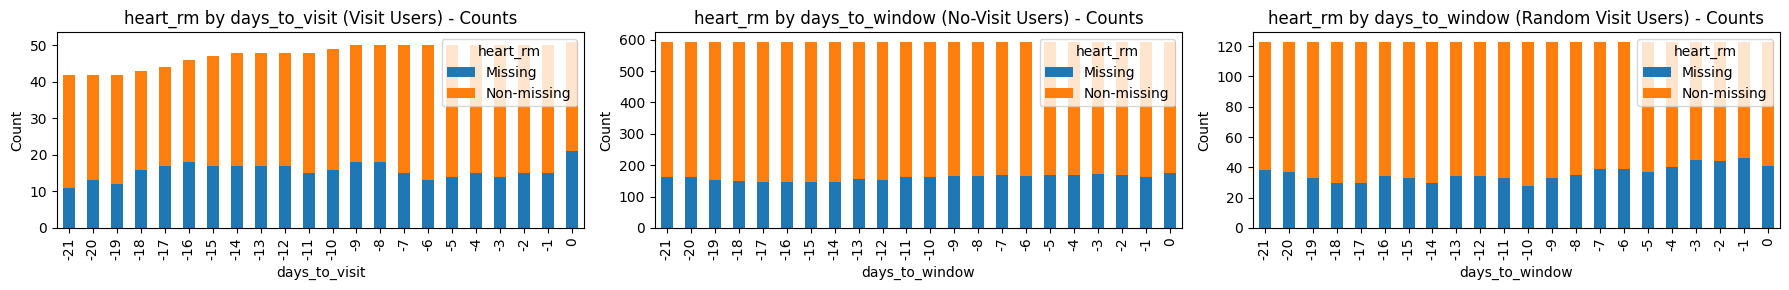

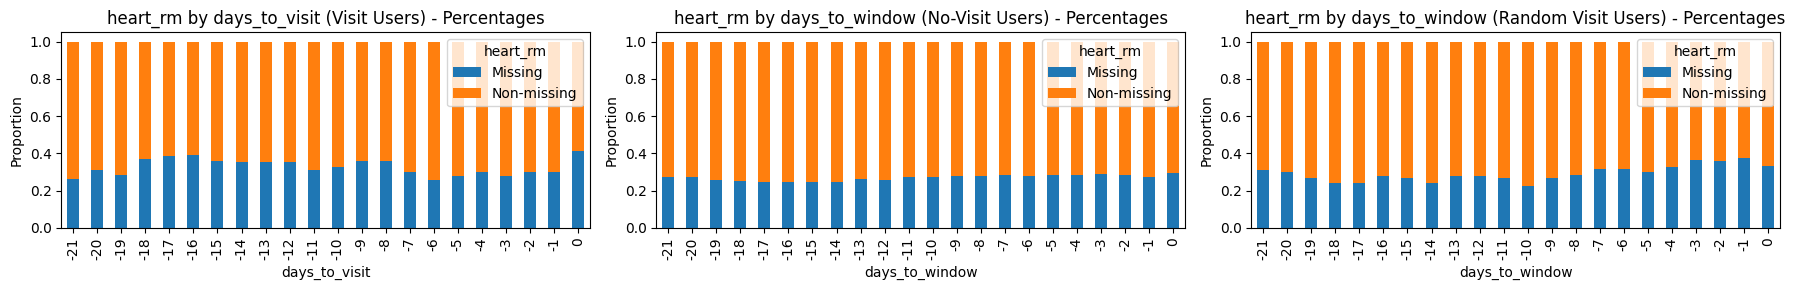

In [51]:
plot_feature_comparison_3(visit_3wk, no_visit_3wk, random_visit_3wk, 'heart_rm', bin_continuous=True)